In [5]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [6]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])
#dataloader
train_path = r'C:\Dataset\Train_set'
test_path = r'C:\Dataset\Test_set'
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

cuda
['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']
Image batch dimensions: torch.Size([128, 1, 300, 300])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([ 0,  8, 22,  9,  7, 18,  9, 19,  1,  6])


In [7]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

77846 23666
Epoch: 0 Train Loss: tensor(2.6480) Train Accuracy: 0.1783649770058834 Test Accuracy: 0.24795064649708443
Epoch: 1 Train Loss: tensor(1.8168) Train Accuracy: 0.42018857744778154 Test Accuracy: 0.31737513732781203
Epoch: 2 Train Loss: tensor(1.0187) Train Accuracy: 0.6723017239164504 Test Accuracy: 0.29358573480943123
Epoch: 3 Train Loss: tensor(0.6412) Train Accuracy: 0.7928859543200678 Test Accuracy: 0.34813656722724584
Epoch: 4 Train Loss: tensor(0.4362) Train Accuracy: 0.8594275878015569 Test Accuracy: 0.31936110876362717
Epoch: 5 Train Loss: tensor(0.3147) Train Accuracy: 0.8976826041158185 Test Accuracy: 0.6101157779092369
Epoch: 6 Train Loss: tensor(0.2206) Train Accuracy: 0.928153020065257 Test Accuracy: 0.5514239837741908
Epoch: 7 Train Loss: tensor(0.1683) Train Accuracy: 0.9444158980551345 Test Accuracy: 0.3926730330431843
Epoch: 8 Train Loss: tensor(0.1318) Train Accuracy: 0.9563111784805899 Test Accuracy: 0.308290374376743
Epoch: 9 Train Loss: tensor(0.0956) Tra

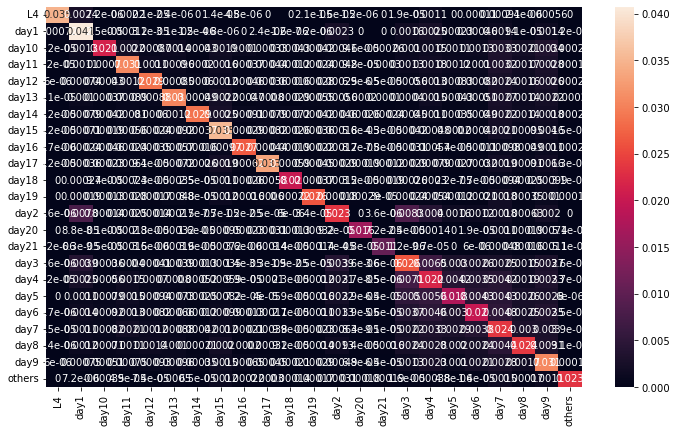

In [8]:
num_epochs=35
model = ResNet(BasicBlock, layers=[2,2,2,2], num_classes=23) # ResNet34

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
loss_function=nn.CrossEntropyLoss()

#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)
#Model training and saving best model
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = []
y_true = []
train_losses = []
test_acc = []
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    train_losses.append(train_loss)
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        
        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    test_accuracy=test_accuracy/test_count
    test_acc.append(test_accuracy)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_ResNet_Implementation_DayWise.model')
        best_accuracy=test_accuracy
        
 # constant for classes
classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

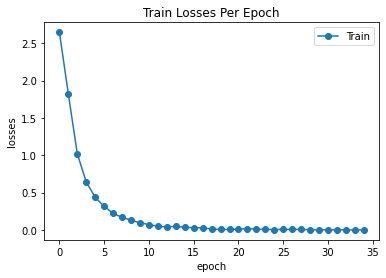

In [9]:
plt.plot(train_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train'])
plt.title('Train Losses Per Epoch')
 
plt.show()

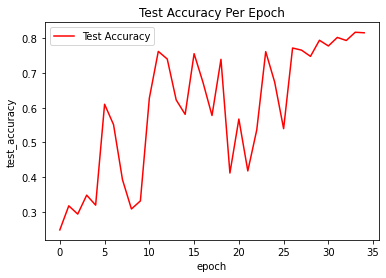

In [10]:
plt.plot(test_acc,'-r')
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.legend(['Test Accuracy'])
plt.title('Test Accuracy Per Epoch')
plt.show()